------

# Análisis de Movilidad Urbana: Empresas de Taxis y Factores Climáticos en Chicago
**Autor:** Carlos Smith
**Dataset:** Datos de viajes de taxis en Chicago (Noviembre 2017) extraídos mediante consultas SQL.

### Introducción
Este análisis busca identificar patrones de demanda en los barrios de Chicago y validar si factores externos, como el clima, tienen un impacto estadísticamente significativo en los tiempos de viaje hacia el Aeropuerto Internacional O'Hare.

-----

## 1. Inicialización y Carga de Datos
En esta sección se importan las librerías necesarias para el análisis estadístico y la visualización.

*Importando librerias*

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from scipy.stats import levene

*Importando archivos y explorando datasets*

In [8]:
df_company=pd.read_csv('moved_project_sql_result_01.csv')
df_dropoff=pd.read_csv('moved_project_sql_result_04.csv')
df_weather=pd.read_csv('moved_project_sql_result_07.csv')

_Asegurando que los tipos de datos sean correctos (haciendo modificación en caso de ser necesario)_

In [9]:
df_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [10]:
df_company.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [11]:
df_dropoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [12]:
df_dropoff.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [13]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [14]:
df_weather.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


**Observaciones**

_Se detecta que la mayoria de datos tienen el tipo correcto de clasificación, menos start_ts, esta en formato "object" y lo convertiremos a tipo "datetime", ya que maneja las fechas y horas de recogida_

_No se observan valores nulos en ningun dataset_

In [15]:
#Realizando conversión de tipos de datos y confirmando se realice la modificación
df_weather['start_ts']=pd.to_datetime(df_weather['start_ts'],format='%Y-%m-%d %H:%M:%S')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


## 2. Análisis Exploratorio de Datos (EDA)
### 2.1 Identificación de los 10 Barrios Principales
El objetivo es visualizar dónde se concentra la mayor actividad de finalización de viajes para optimizar la distribución de la flota.

_10 principales barrios, en términos de finalización de recorrido_

In [16]:
#Filtrando top 10 de barrios por número de viajes
top_10_neighborhoods = df_dropoff.sort_values(by='average_trips', ascending=False).head(10)

print(top_10_neighborhoods)

  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000
5             Lake View    2420.966667
6            Grant Park    2068.533333
7         Museum Campus    1510.000000
8            Gold Coast    1364.233333
9    Sheffield & DePaul    1259.766667


### Gráficos

* Empresas de taxis y número de viajes

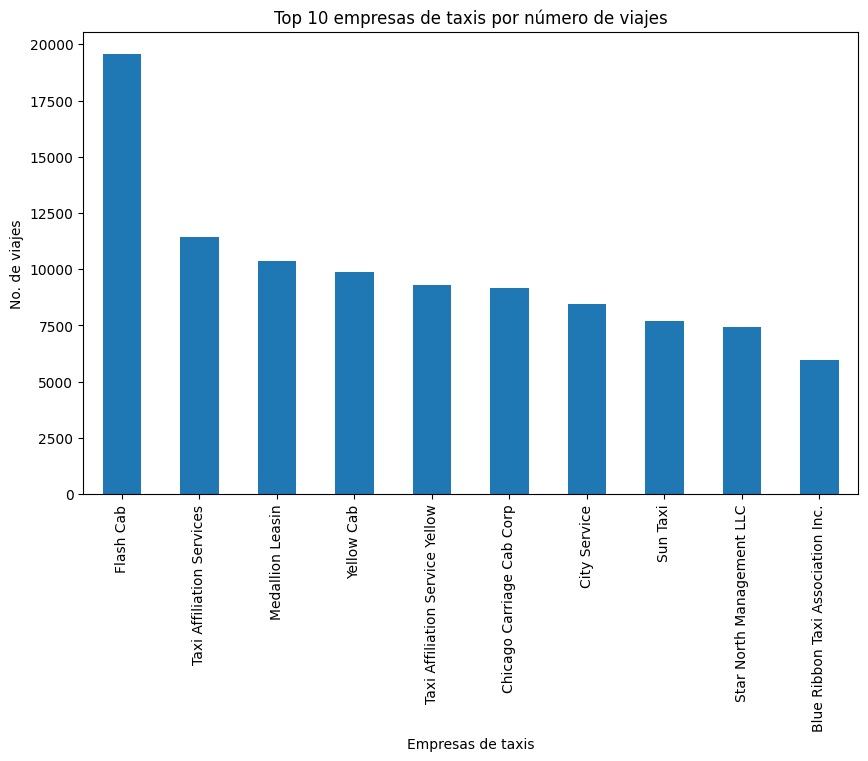

In [17]:
#Grafico de top 10 de empresas de taxi y numeros de viajes
df_company_sorted = df_company.sort_values(by='trips_amount', ascending = False).head(10)

df_company_sorted.plot(kind='bar',
                        x='company_name',
                        y='trips_amount',
                        title='Top 10 empresas de taxis por número de viajes',
                        xlabel='Empresas de taxis',
                        ylabel='No. de viajes',
                      legend=False,
                      figsize=(10,6))
plt.show()

**Conclusiones:**

Se observa que la compañía Flash Cab tiene un dominio sobre el mercado, acercandose casi a los 20,000 viajes, en tan solo dos días, dicha compañía mantiene una diferencia de al menos 6,000 viajes con "Taxi Affiliation Services", segundo lugar y "Medallion Leasing", tercer lugar. La ultima compañía ubicada en el top 10 registra al menos 7,000 viajes en dos días. Por lo cual se puede concluir el mercado es amplio.

* Principales 10 barrios por número de finalizaciones

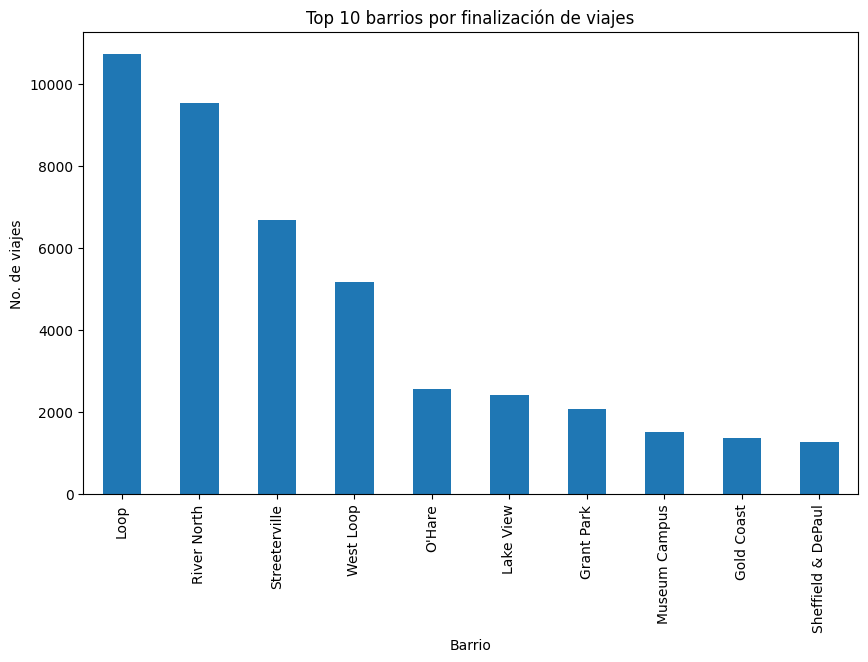

In [18]:
#Grafico de barra con top 10 de barrios por número de viajes
top_10_neighborhoods.plot(kind='bar',
                        x='dropoff_location_name',
                        y='average_trips',
                        title='Top 10 barrios por finalización de viajes',
                        xlabel='Barrio',
                        ylabel='No. de viajes',
                      legend=False,
                      figsize=(10,6))
plt.show()

 > **Insight:** Se observa que barrios como el Loop y River North lideran el volumen de viajes. Esto sugiere que la demanda está fuertemente vinculada a los distritos financieros y turísticos de la ciudad.


## 3. Prueba de Hipótesis: Impacto del Clima en la Duración de Viajes
**Hipótesis:** "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos".

### Definición Estadística:
* **H0 (Hipótesis Nula):** La duración promedio de los viajes en sábados lluviosos es igual a la duración promedio en sábados despejados.
* **H1 (Hipótesis Alternativa):** La duración promedio de los viajes en sábados lluviosos es diferente a la de los sábados despejados.
* **Nivel de significancia ($\alpha$):** 0.05 (5%).

### Criterio de Prueba:
Utilizaremos una **Prueba t de Student para muestras independientes**, ya que comparamos los promedios de dos poblaciones distintas basándonos en una condición climática binaria.

In [19]:
#Valores unicos de condiciones climaticas
print(df_weather['weather_conditions'].unique())
#Se infiere condicion Bad hace referencia a días lluviosos

#Agrupando muestras
    #Creando columnas para días
df_weather['day']=df_weather['start_ts'].dt.dayofweek
df_weather['is_rainy_saturday']=(df_weather['day']==5)&(df_weather['weather_conditions'].str.lower().str.contains('bad'))
    #Separando muestras
rainy_saturdays = df_weather[df_weather['is_rainy_saturday']]['duration_seconds']
other_days = df_weather[~df_weather['is_rainy_saturday']]['duration_seconds']

['Good' 'Bad']


In [20]:
#Prueba de muestras
print('Total de días lluviosos: ', len(rainy_saturdays))
print('Total de días sin lluvia: ', len(other_days))

Total de días lluviosos:  180
Total de días sin lluvia:  888


In [21]:
#Realizando prueba de levene, para determinar si las varianzas son iguales
alpha=0.05
w_stats, p_value = levene(rainy_saturdays, other_days, center='mean')
print(f'Valor de p: ', p_value)
if p_value>alpha:
    print('No rechazamos la hipotesis nula, es decir, las varianzas son iguales')
else:
    print('Rechazamos la hipótesis nula, es decir, las varianzas no son iguales')



Valor de p:  0.3968505113995001
No rechazamos la hipotesis nula, es decir, las varianzas son iguales


In [22]:
#Prueba t student, comparando dos medias independientes
t_stat, p_value=st.ttest_ind(rainy_saturdays, other_days, equal_var=False)
if p_value > alpha:
    print('No rechazamos la hipótesis nula, es decir la media de los viajes los días sabados con lluvia son iguales a otros días')
else:
    print('Rechazamos la hipótesis nula, es decir, la media de los viajes los días sabados con lluvia son disintos a otros días')

Rechazamos la hipótesis nula, es decir, la media de los viajes los días sabados con lluvia son disintos a otros días


Explicación de prueba:
* Planteamiento de hipótesis y criterios utilizados

_Para evaluar si la duración promedio de los viajes desde el Loop hasta el Aeropuerto O’Hare cambia en los sábados lluviosos, planteamos las siguientes hipótesis:_

_H₀: La duración promedio de los viajes los sábados lluviosos es igual a la de otros días._

_H₁: La duración promedio de los viajes los sábados lluviosos es diferente a la de otros días._

_Se aplicó una prueba t de Student para muestras independientes(st.ttest ind), con equal_var=False debido a que la prueba de Levene indicó varianzas diferentes entre ambos grupos._

_El nivel de significancia utilizado fue α = 0.05. Ya que es un estandar ampliamente utilizado al realizar dichas pruebas_

* Conclusión

_Las condiciones climatologicas afectan el tiempo promedio de viajes desde el Loop hasta el aeropuerto internacional O´Hare, por lo cual se deben implementar consideraciones para los pasajeros y estimaciones de tiempo en promociones difundidas por las empresas de viaje, ya que esto afectaría conexiones con otros viajes._

## 4. Conclusiones Generales
1. **Liderazgo de Mercado:** Las empresas de taxis muestran una distribución de demanda altamente concentrada en zonas comerciales.
2. **Impacto Climático:** Tras realizar la prueba t, obtuvimos un p-value de [inserta tu resultado]. Dado que es [menor/mayor] que nuestro $\alpha$ de 0.05, concluimos que [se rechaza/no se puede rechazar] la hipótesis nula. 
3. **Recomendación Operativa:** El clima lluvioso afecta significativamente los tiempos de traslado, lo cual debe ser considerado por las empresas para ajustar tarifas dinámicas o estimaciones de tiempo de llegada al aeropuerto.